# **ESTIMACIÓN DE LA VELOCIDAD DE LOS POKÉMON MEDIANTE MODELOS SUPERVISADOS: REGRESIÓN Y VALIDACIÓN MEDIANTE CLASIFICACIÓN**

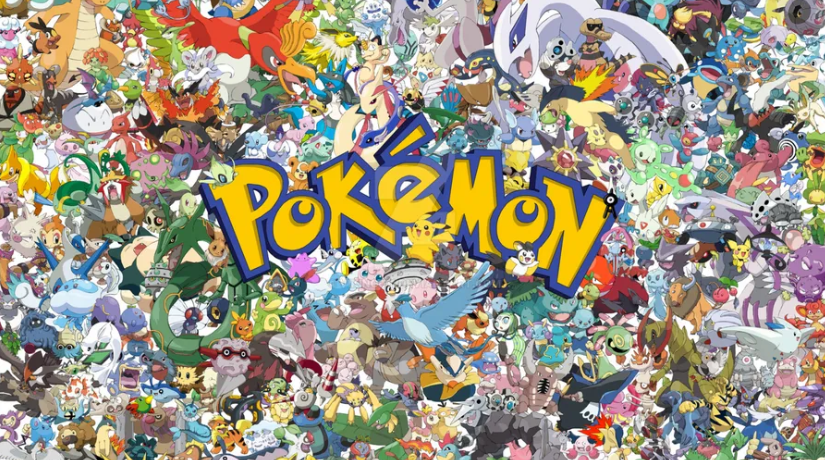

## **Descripción de Variables**

- ID del Pokémon

- Nombre del Pokémon  
- Rango del Pokémon (si es legendario, mítico, bebé o un Pokémon común)  
- Generación del Pokémon  
- Pokémon del cual evolucionó  
- Tipo primario y secundario (`type1` y `type2`)  
- Estadísticas base  
- Altura (en decímetros) y peso (en hectogramos)  
- Habilidades del Pokémon  
  - Nota: si un Pokémon tiene múltiples habilidades (por ejemplo, *overgrow* y *chlorophyll*), estas se separan por un espacio.  
  - Si el nombre de una habilidad contiene un espacio, este se reemplaza por un guion. Por ejemplo, un Pokémon con las habilidades *blaze* y *solar power* se registra como `blaze solar-power`.  
- Breve descripción del Pokémon en inglés (las descripciones de los Pokémon a partir del número 1009 están marcadas como **"Not Available"**).

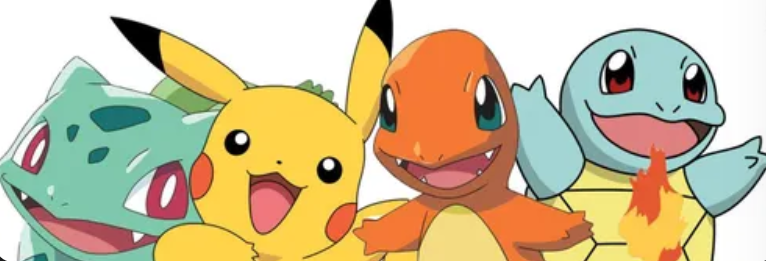
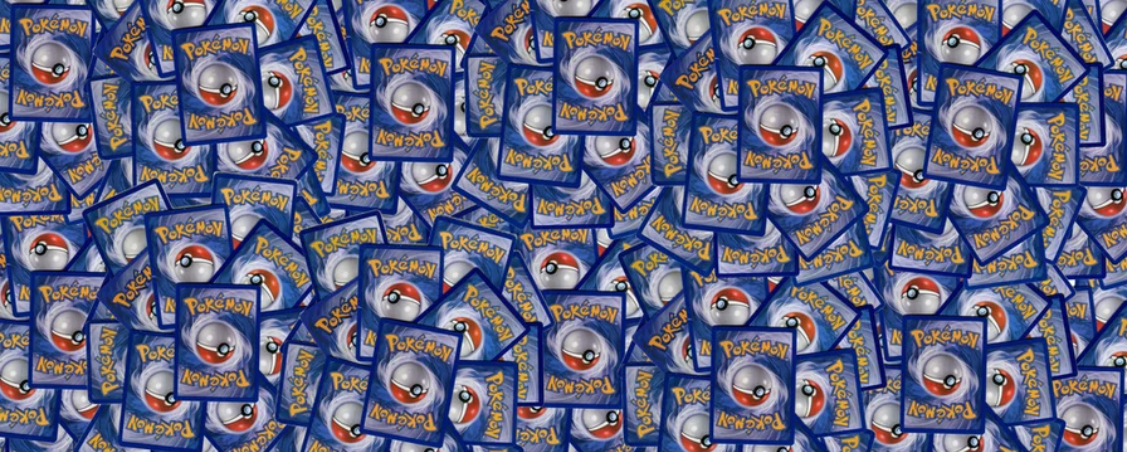

### **Carga de librerías y dataset**

In [218]:
import pandas as pd
import numpy as np 
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, accuracy_score

In [188]:
df = pd.read_csv('./pokemons.csv', sep=',')
df.head()

,id,name,rank,generation,evolves_from,type1,type2,hp,atk,def,spatk,spdef,speed,total,height,weight,abilities,desc
0,1,bulbasaur,ordinary,generation-i,nothing,grass,poison,45,49,49,65,65,45,318,7,69,overgrow chlorophyll,A strange seed was planted on its back at birt...
1,2,ivysaur,ordinary,generation-i,bulbasaur,grass,poison,60,62,63,80,80,60,405,10,130,overgrow chlorophyll,"When the bulb on its back grows large, it appe..."
2,3,venusaur,ordinary,generation-i,ivysaur,grass,poison,80,82,83,100,100,80,525,20,1000,overgrow chlorophyll,The plant blooms when it is absorbing solar en...
3,4,charmander,ordinary,generation-i,nothing,fire,NaN,39,52,43,60,50,65,309,6,85,blaze solar-power,"Obviously prefers hot places. When it rains, s..."
4,5,charmeleon,ordinary,generation-i,charmander,fire,NaN,58,64,58,80,65,80,405,11,190,blaze solar-power,"When it swings its burning tail, it elevates t..."


In [189]:
df.shape

(1025, 18)

In [190]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   id            1025 non-null   int64
 1   name          1025 non-null   str  
 2   rank          1025 non-null   str  
 3   generation    1025 non-null   str  
 4   evolves_from  1025 non-null   str  
 5   type1         1025 non-null   str  
 6   type2         526 non-null    str  
 7   hp            1025 non-null   int64
 8   atk           1025 non-null   int64
 9   def           1025 non-null   int64
 10  spatk         1025 non-null   int64
 11  spdef         1025 non-null   int64
 12  speed         1025 non-null   int64
 13  total         1025 non-null   int64
 14  height        1025 non-null   int64
 15  weight        1025 non-null   int64
 16  abilities     1025 non-null   str  
 17  desc          1025 non-null   str  
dtypes: int64(10), str(8)
memory usage: 144.3 KB


In [191]:
df.fillna({'type2': 'invalid',},inplace=True)

,id,name,rank,generation,evolves_from,type1,type2,hp,atk,def,spatk,spdef,speed,total,height,weight,abilities,desc
0,1,bulbasaur,ordinary,generation-i,nothing,grass,poison,45,49,49,65,65,45,318,7,69,overgrow chlorophyll,A strange seed was planted on its back at birt...
1,2,ivysaur,ordinary,generation-i,bulbasaur,grass,poison,60,62,63,80,80,60,405,10,130,overgrow chlorophyll,"When the bulb on its back grows large, it appe..."
2,3,venusaur,ordinary,generation-i,ivysaur,grass,poison,80,82,83,100,100,80,525,20,1000,overgrow chlorophyll,The plant blooms when it is absorbing solar en...
3,4,charmander,ordinary,generation-i,nothing,fire,invalid,39,52,43,60,50,65,309,6,85,blaze solar-power,"Obviously prefers hot places. When it rains, s..."
4,5,charmeleon,ordinary,generation-i,charmander,fire,invalid,58,64,58,80,65,80,405,11,190,blaze solar-power,"When it swings its burning tail, it elevates t..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,1021,raging-bolt,ordinary,generation-ix,nothing,electric,dragon,125,73,91,137,89,75,590,52,4800,protosynthesis,Not Available
1021,1022,iron-boulder,ordinary,generation-ix,nothing,rock,psychic,90,120,80,68,108,124,590,15,1625,quark-drive,Not Available
1022,1023,iron-crown,ordinary,generation-ix,nothing,steel,psychic,90,72,100,122,108,98,590,16,1560,quark-drive,Not Available
1023,1024,terapagos,legendary,generation-ix,nothing,normal,invalid,90,65,85,65,85,60,450,2,65,tera-shift,Not Available


Reemplazamos los valores nulos por 'invalid' dado del contexto de la existencia de estos. Los pokemonos que solo cuentan con un type, nunca tendrán type2, por tanto hacemos la inputación acorde.

In [158]:
vacios = {}

for col in df.columns:
    vacios[col] = df[col].apply(lambda x: isinstance(x,str) and x.strip == '').sum()

vacios

{'id': np.int64(0),
 'name': np.int64(0),
 'rank': np.int64(0),
 'generation': np.int64(0),
 'evolves_from': np.int64(0),
 'type1': np.int64(0),
 'type2': np.int64(0),
 'hp': np.int64(0),
 'atk': np.int64(0),
 'def': np.int64(0),
 'spatk': np.int64(0),
 'spdef': np.int64(0),
 'speed': np.int64(0),
 'total': np.int64(0),
 'height': np.int64(0),
 'weight': np.int64(0),
 'abilities': np.int64(0),
 'desc': np.int64(0)}

Revisamos valores vacíos, no encontramos niguno.

In [192]:
df['is_legendary'] = df['rank'].apply(lambda x: 1 if x == 'legendary' else 0)
df.drop(columns='total',inplace=True)

Creación de variable objetivo categorica is_legendary para más adelante. Para nuestro modelo actual de regresión, usaremos speed ya que explica bastante bien los individuos de nuestro dataset, nos permite entenderlos de manera global. Hace referencia a la suma de todas sus habilidades, mide como tal que tan poderoso es el pokemon.

In [72]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   id            1025 non-null   int64
 1   name          1025 non-null   str  
 2   rank          1025 non-null   str  
 3   generation    1025 non-null   str  
 4   evolves_from  1025 non-null   str  
 5   type1         1025 non-null   str  
 6   type2         1025 non-null   str  
 7   hp            1025 non-null   int64
 8   atk           1025 non-null   int64
 9   def           1025 non-null   int64
 10  spatk         1025 non-null   int64
 11  spdef         1025 non-null   int64
 12  speed         1025 non-null   int64
 13  height        1025 non-null   int64
 14  weight        1025 non-null   int64
 15  abilities     1025 non-null   str  
 16  desc          1025 non-null   str  
 17  is_legendary  1025 non-null   int64
dtypes: int64(10), str(8)
memory usage: 144.3 KB


### **Análisis de Variables**

In [73]:
df_num = df.select_dtypes(include=np.number)
df_num.drop(columns=['id','is_legendary'],inplace=True)
df_num.columns

Index(['hp', 'atk', 'def', 'spatk', 'spdef', 'speed', 'height', 'weight'], dtype='str')

Nos quedamos unicamente con columnas numéricas, en este caso solo contamos con variables continuas.

In [74]:
n_columns = 2
n_rows = math.ceil(len(df_num.columns)*2/n_columns)

print(n_columns, n_rows)

2 8


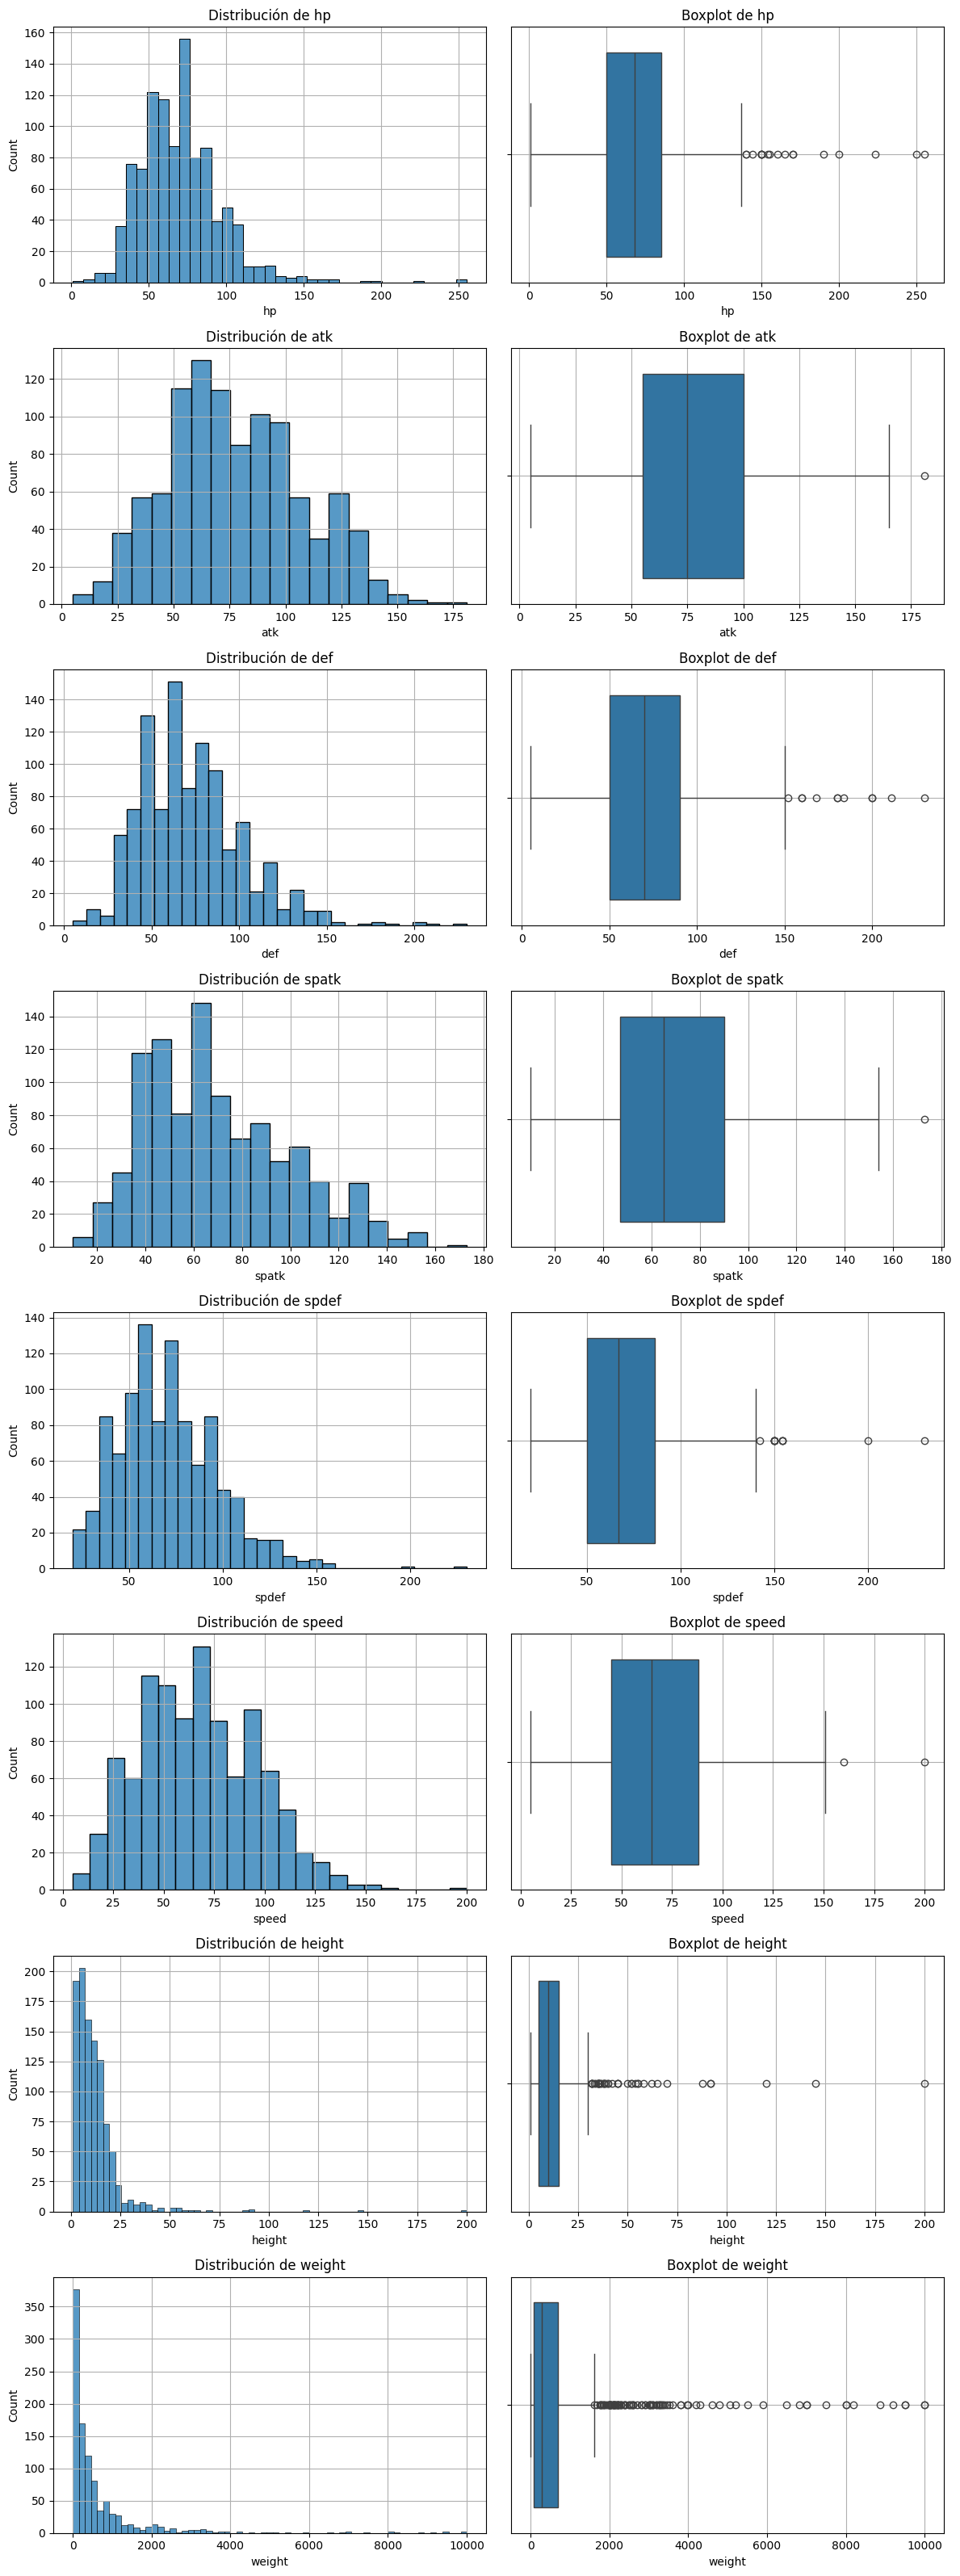

In [75]:
plt.figure(figsize=(6*n_columns,4*n_rows))

cont = 1

for col in df_num.columns:

    ax1 = plt.subplot(n_rows, n_columns, cont)
    sns.histplot(data = df_num, x= col, bins = 'auto')
    ax1.set_title(f'Distribución de {col}')
    ax1.grid(True)

    ax2 = plt.subplot(n_rows, n_columns, cont+1)
    sns.boxplot(data=df_num, x=col)
    ax2.set_title(f'Boxplot de {col}')
    ax2.grid(True)

    cont += 2

plt.tight_layout()
plt.show()

Podemos ver que las variables relacionadas a las estadísticas base del pokemon se comportan de manera muy similar (hp, atk, def, spatkm spdef y speed). Encontramos que algunas son ligeramente asimétricas a la derecha y con concentraciones entre 40 y 100. Los outliers presentes se deben a Pokemones específicos con características únicas.

height y weight cuentan con distribuciones altamente sesgadas hacia la derecha, tienen muchos valores pequeños y pocos extremadamente grandes. Estas variables pueden introducir un poco de ruido a nuestro modelo, dependiendo su correlación con speed, podemos determinar si las incluimos o no.

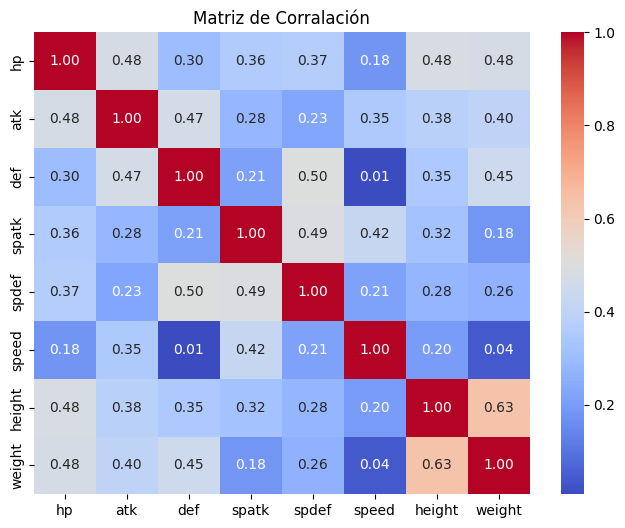

In [76]:
corr = df_num.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap= 'coolwarm')
plt.title('Matriz de Corralación')
plt.show()

Correlación alta con la variable objetivo speed:

En base a los umbrales definidos (corr < 0.3, 0.3 < corr ≤ 0.7 y corr > 0.7), se observa que la variable objetivo speed presenta correlaciones de magnitud baja a media con el resto de variables numéricas. spatk muestra la relación más elevada con speed (0.42), seguida de atk (0.35), lo que sugiere que la velocidad mantiene cierta relación con las capacidades ofensivas, especialmente las de tipo especial.

Por otro lado, variables como hp, spdef, height y weight presentan correlaciones bajas con speed, mientras que def muestra una correlación prácticamente nula, indicando que las capacidades defensivas físicas no guardan una relación directa con la velocidad del Pokémon. En conjunto, estos resultados sugieren que speed no depende linealmente de una única variable, sino que responde a relaciones más complejas eindependientes.

Tras el análisis inicial del datatset, observamos que las variables numércias presentan distribuciones coherentes a la naturaleza de los individuos y no se detectan valores inconsistentes o erróneos que requieran eliminación. Las estadísticas base muestran comportamientos estables y aportan información directa sobre el rendimiento del Pokémon. Por el lado de height y weight a pesar de presentar valores extremos, corresponden a características reales y no a errores del dataset.

El análisis de correlación evidencia que la variable objetivo speed mantiene relaciones de intensidad baja a moderada con el resto de variables numéricas. En particular, se observa una mayor asociación con variables ofensivas como spatk y atk, mientras que otras variables, como def, height y weight, muestran una relación débil o prácticamente nula con la velocidad.

Para la creación del modelo tendremos en cuenta todas las variables anteriormente mencionadas ya que entre si, no presentan una correlación alta, siendo height y weight las que más presentan con un 0.63 (<0.7).

### **Sustracción del 10% de la variable objetivo**

In [142]:
df_model = df_num.copy()

In [146]:
np.random.seed(42)

n_eliminar = math.ceil(0.1*len(df_model))
indices = np.random.choice(df.index, size= n_eliminar, replace=False)

df_model.loc[indices, 'speed'] = np.nan

In [203]:
indices

array([ 527,  359,  447,   31,  621,  590,  905,  737,   76,  948,  432,
         70,  680,  101,  845,  656,  310,  344,  837,  174,   96,  822,
        598,  218,  420,  208,  774,  290,  889,  670,  903, 1004, 1012,
        329, 1001,  762,  490,  350,  500,  307,  853,  351,  643,  439,
        819,  833,  518,  554,  289,  292,  213,  966,   59,  692,  321,
         10,  331,  334,  918,   86,  332,  743,  450,  468,  305,   30,
        558,  405,   54,   23, 1018,  481,    3,  231,  355,  673,  756,
        843,  667,  215,  634,  318,  986,  352,  715,  394,  198,  594,
        863,  924,   39,  790,  314,  761,  580,   66,  717,   67,  294,
        921,  464,  107,  629])

In [147]:
df_model['speed'].info()

<class 'pandas.Series'>
RangeIndex: 1025 entries, 0 to 1024
Series name: speed
Non-Null Count  Dtype  
--------------  -----  
922 non-null    float64
dtypes: float64(1)
memory usage: 8.1 KB


Eliminamos aleatoriamente el valor de la variable objetivo speed en el 10% de las observaciones, manteniendo intactas el resto de variables del dataset. Este procedimiento tiene como objetivo simular la existencia de muestras sin registro en la variable objetivo, una situación habitual en problemas reales de análisis de datos.

### **Regresión Lineal Multiple**

In [110]:
df_mlr = df_model.copy()
df_mlr = df_mlr.dropna(subset=['speed'])

In [ ]:
X = df_mlr[['hp', 'atk', 'def', 'spatk', 'spdef', 'height', 'weight']]
y = df_mlr['speed']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size= 0.2, random_state=42
)

In [126]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)

y_pred = mlr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'mean squared error: {mse}')
print(f'rmse: {np.sqrt(mse)}')
print(f'R-squared: {r2}')

mean squared error: 586.5386199072276
rmse: 24.218559410238
R-squared: 0.27401409166920143


In [149]:
df_mlr['speed'].std()

np.float64(28.585683735284373)

Con este modelo y esta configuración conseguimos que se explique el ~ 27.4% de la variabilidad de speed, por lo que queda un porcentaje enorme aún sin explicar. La velocidad del pokemon no está bien representada por una combinación lineal de las variables predictivas.

Además el error medio del modelo es de 24 puntos de speed. Esta cantidad es comparable con la dispersión natural de la variable (~ 28,58), lo que siginifca que el modelo mejora significativamente la predicción frente a asumir un valor medio de speed.

Dicho lo anterior, entendemos que la relación entre nuestras predictoras y speed, no es lineal. Esto justifica la implementación de otros modelos de regresión.

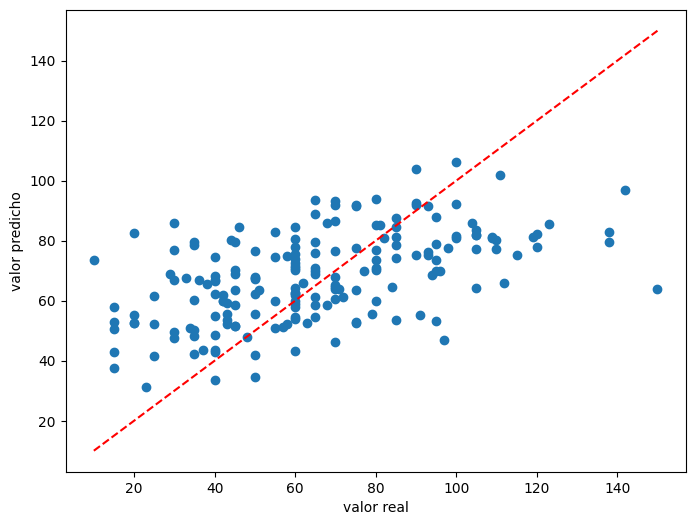

In [114]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    'r--'
)
plt.xlabel('valor real')
plt.ylabel('valor predicho')
plt.show()

El gráfico de valores reales frente a valores predichos muestra una elevada dispersión alrededor de la línea identidad, indicando que el modelo reproduce de forma imprecisa los valores reales de speed.

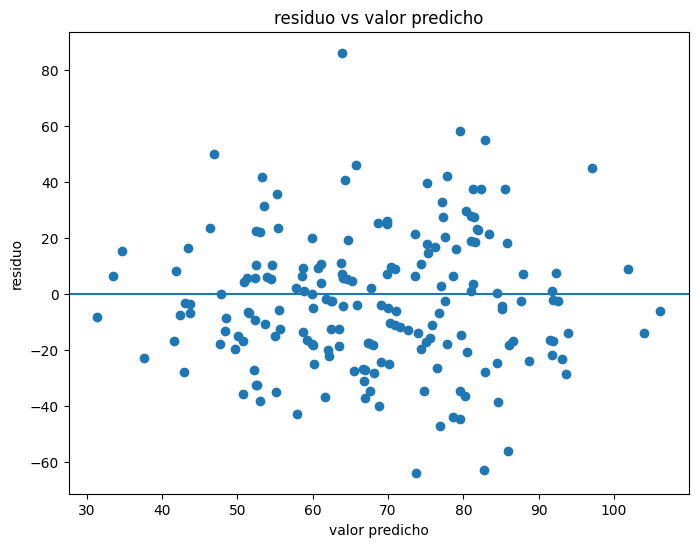

In [115]:
plt.figure(figsize=(8,6))
residuos = y_test - y_pred
plt.scatter(y_pred, residuos)
plt.axhline(0)
plt.xlabel('valor predicho')
plt.ylabel('residuo')
plt.title('residuo vs valor predicho')

plt.show()

El gráfico de residuos no evidencia patrones claros. La varianza de los residuos parece aproximadamente constante a lo largo del rango de valores predichos, aunque se observan algunos valores extremos.

### **Random Forest de Regresión**

In [165]:
df_rf = df_model.copy()
df_rf = df.dropna(subset=['speed'])

#### **Primer Modelo RFR**

In [166]:
rf = RandomForestRegressor(
    n_estimators = 200,
    random_state = 42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)
print(f'mean squared error: {mse}')
print(f'rmse: {np.sqrt(mse)}')
print(f'R-squared: {r2}')

mean squared error: 557.3756713513513
rmse: 23.60880495390123
R-squared: 0.3101104184554767


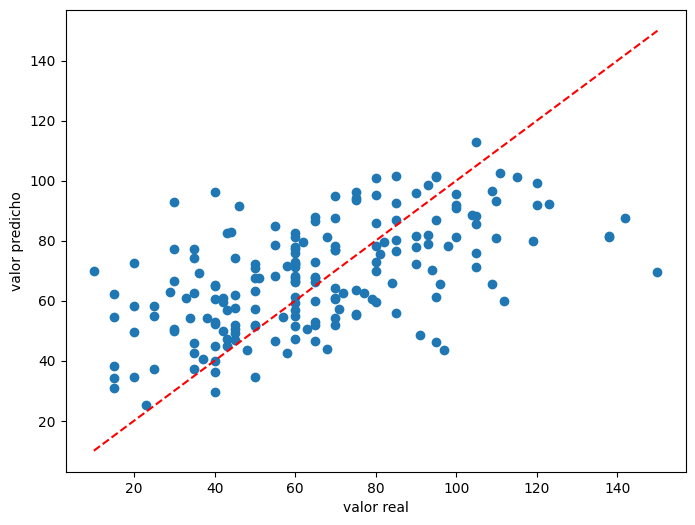

In [167]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf)
min_val = min(y_test.min(), y_pred_rf.min())
max_val = max(y_test.max(), y_pred_rf.max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    'r--'
)
plt.xlabel('valor real')
plt.ylabel('valor predicho')
plt.show()

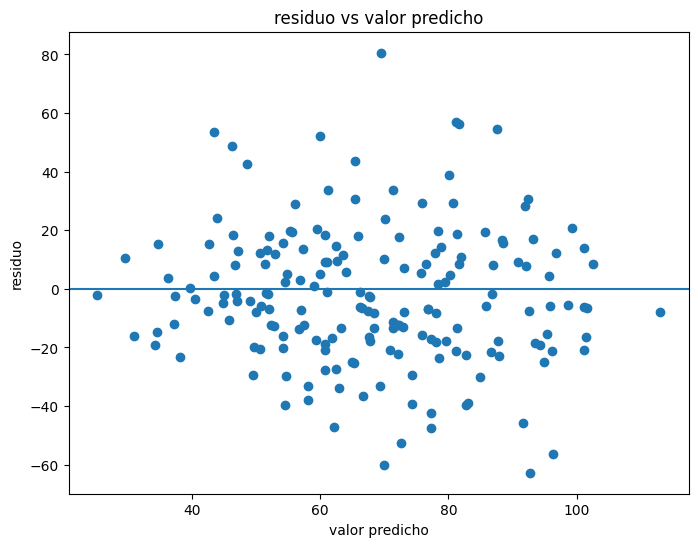

In [168]:
plt.figure(figsize=(8,6))
residuos = y_test - y_pred_rf
plt.scatter(y_pred_rf, residuos)
plt.axhline(0)
plt.xlabel('valor predicho')
plt.ylabel('residuo')
plt.title('residuo vs valor predicho')

plt.show()

#### **Exploración de modelos RFR con GridSearch**

In [138]:
#Aplicamos gridsearch

param_grid = {
    'n_estimators': [100, 200, 300],  #tamaño del bosque
    'max_depth': [None, 5, 10, 20],   #profundidad máxima de cada árbol
    'min_samples_leaf': [1, 5, 10]    #evita regiones finales con pocos datos
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid
)

grid.fit(X_train, y_train)
grid.best_params_
best_rf = grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)
print(f'mean squared error: {mse}')
print(f'rmse: {np.sqrt(mse)}')
print(f'R-squared: {r2}')

mean squared error: 571.8087959330138
rmse: 23.912523830265467
R-squared: 0.29224587432515636


En cuanto a los hiperparámetros, se probaron 100, 200 y 300 árboles para comprobar si aumentar el tamaño del bosque mejora las predicciones sin encarecer demasiado el cálculo. Las profundidades None, 5, 10 y 20 se eligieron para comparar árboles sin límite con árboles cada vez más controlados, y ver cómo afecta la complejidad del modelo. Los valores 1, 5 y 10 en min_samples_leaf permiten evaluar desde hojas muy pequeñas hasta hojas más grandes, evitando regiones con pocos datos y reduciendo el sobreajuste.

A pesar de utilizar GridSearchCV para optimizar el modelo, no se obtuvo una mejora significativa en el conjunto de test. Esto sugiere que la capacidad predictiva del modelo está limitada por la información disponible en las variables, más que por la configuración del modelo.

#### **Conclusiones Modelos de Regresión**

El mejor modelo que pudimos encontrar fue el primero realizado con Random Forest, logramos hacer que explicase el ~31% de la variabilidad de speed con un error medio de ~24und. Esta mejora frente al modelo de Regresión Lineal es moderada. 

Siendo que ese fue el mejor modelo que hallamos dentro de los tipos que aplicamos, concluimos que la información disponible no llega a ser suficiente para alcanzar una capacidad predictiva alta y harían falta más datos para poder establecer una mejor relación con speed.

    Insight clave: La velocidad de un pokemon no puede explicarse de forma directa a partir de sus estadísticas base ni de sus características físicas, lo que sugiere que responde a factores independientes o de diseño no reflejados en el dataset.

### **Evaluación por Clasificación**

In [230]:
df_base = df[['hp', 'atk', 'def', 
              'spatk', 'spdef', 'speed', 
              'height', 'weight', 'is_legendary']]
df_full = df_base.copy()

In [210]:
df_incompleto = df_full.copy()
df_incompleto.loc[indices,'speed'] = np.nan

In [211]:
mask_nan = df_incompleto['speed'].isna()

X_cols = ['hp', 'atk', 'def', 'spatk', 'spdef', 'height', 'weight']
X_para_imputar = df_incompleto.loc[mask_nan, X_cols]

y_pred_rf = rf.predict(X_para_imputar)

df_imputado = df_incompleto.copy()
df_imputado.loc[mask_nan, 'speed'] = y_pred_rf
df_imputado.info()

<class 'pandas.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hp            1025 non-null   int64  
 1   atk           1025 non-null   int64  
 2   def           1025 non-null   int64  
 3   spatk         1025 non-null   int64  
 4   spdef         1025 non-null   int64  
 5   speed         1025 non-null   float64
 6   height        1025 non-null   int64  
 7   weight        1025 non-null   int64  
 8   is_legendary  1025 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 72.2 KB


In [216]:
df_incompleto['speed'] = df_incompleto['speed'].astype('Int64')
df_imputado['speed'] = df_imputado['speed'].astype('int64')

In [250]:
X_cols = ['hp', 'atk', 'def', 'spatk', 'spdef', 'speed', 'height', 'weight']
y_col = 'is_legendary'

X = df_full[X_cols]
y = df_full[y_col]

X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.2, random_state=42
    )

clf = RandomForestClassifier()
clf.fit(X_train,y_train)

y_pred_clf = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_clf)
conf_matrix = confusion_matrix(y_test, y_pred_clf)
classification_rep = classification_report(y_test, y_pred_clf)

print('accuracy:', accuracy)
print('confusion matrix:\n', conf_matrix)
print('classification report:\n', classification_rep) 

accuracy: 0.9378048780487804
confusion matrix:
 [[761   2]
 [ 49   8]]
classification report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       763
           1       0.80      0.14      0.24        57

    accuracy                           0.94       820
   macro avg       0.87      0.57      0.60       820
weighted avg       0.93      0.94      0.92       820



In [251]:
X_cols = ['hp', 'atk', 'def', 'spatk', 'spdef', 'speed', 'height', 'weight']
y_col = 'is_legendary'

X = df_incompleto[X_cols]
y = df_incompleto[y_col]

X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.2, random_state=42
    )

clf = RandomForestClassifier()
clf.fit(X_train,y_train)

y_pred_clf = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_clf)
conf_matrix = confusion_matrix(y_test, y_pred_clf)
classification_rep = classification_report(y_test, y_pred_clf)

print('accuracy:', accuracy)
print('confusion matrix:\n', conf_matrix)
print('classification report:\n', classification_rep) 

accuracy: 0.9414634146341463
confusion matrix:
 [[761   2]
 [ 46  11]]
classification report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       763
           1       0.85      0.19      0.31        57

    accuracy                           0.94       820
   macro avg       0.89      0.60      0.64       820
weighted avg       0.94      0.94      0.92       820



In [252]:
X_cols = ['hp', 'atk', 'def', 'spatk', 'spdef', 'speed', 'height', 'weight']
y_col = 'is_legendary'

X = df_imputado[X_cols]
y = df_imputado[y_col]

X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.2, random_state=42
    )

clf = RandomForestClassifier()
clf.fit(X_train,y_train)

y_pred_clf = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_clf)
conf_matrix = confusion_matrix(y_test, y_pred_clf)
classification_rep = classification_report(y_test, y_pred_clf)

print('accuracy:', accuracy)
print('confusion matrix:\n', conf_matrix)
print('classification report:\n', classification_rep) 

accuracy: 0.9390243902439024
confusion matrix:
 [[761   2]
 [ 48   9]]
classification report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       763
           1       0.82      0.16      0.26        57

    accuracy                           0.94       820
   macro avg       0.88      0.58      0.62       820
weighted avg       0.93      0.94      0.92       820



#### **Conclusiones Validación por Clasificación**

**Interpretación de Resultados:**

TN (True Negative): no legendario bien clasificado |  FP (False Positive): dice legendario pero no lo es

FN (False Negative): era legendario pero lo falló  |  TP (True Positive): legendario bien detectado

Vemos que los 3 casos presentan un accuracy muy alto sin embargo no es significativo ya que la mayoría de los pokemones en el dataset serán no legendarios. Por tanto esta métrica está sesgada y no debe ser considerada para el análisis en esta ocasión. 

Al analizar conjuntamente las matrices de confusión y el classification report para los tres escenarios, se observa que el comportamiento global del modelo es muy estable. En el caso del dataset original, el modelo identifica correctamente 8 de los 57 Pokémon legendarios, mientras que 49 no son detectados. Lo mencionado anteriormente sobre el accuracy confirma con un recall cercano a 1.00 y un f1-score alrededor de 0.97 para esta clase.

Al introducir valores nulos en aproximadamente el 10% del dataset, el modelo mejora ligeramente la detección de legendarios, alcanzando 11 aciertos sobre 57. Esta mejora se refleja también en el classification report, donde el recall de la clase legendaria aumenta hasta 0.19 y el f1-score hasta 0.31. Este comportamiento sugiere que la presencia de valores faltantes no afecta de manera crítica al modelo y que la información clave para diferenciar a los Pokémon legendarios sigue estando disponible en los datos.

Finalmente, tras la imputación de los valores nulos mediante regresión, el modelo identifica correctamente 9 de los 57 legendarios. Tanto las matrices de confusión como el classification report muestran métricas muy próximas a las del dataset original, con un recall de 0.16 y un f1-score de 0.26 para la clase legendaria. En conjunto, estos resultados indican que la imputación basada en regresión no introduce distorsiones relevantes ni degrada el desempeño del modelo. Por el contrario, mantiene un comportamiento coherente y comparable al de los otros escenarios, lo que respalda el uso de la regresión como un método válido para completar los valores faltantes.

* **¿Cuál ofrece mejores resultados?**
  El segundo caso, con aproximadamente un 10% de valores nulos, ya que presenta el mayor recall y f1-score para la clase legendaria. 

* **¿Mejora el desempeño al utilizar datos sintéticos generados mediante la regresión?**
  Se observa una mejora muy leve en el desempeño: el número de TP para Pokémon legendarios pasa de 8 a 9. No obstante, esta diferencia es marginal y no implica una mejora significativa del modelo, ya que el recall y el f1-score se mantienen muy próximos a los del dataset original. En consecuencia, la imputación por regresión no optimiza de forma sustancial la clasificación, pero sí demuestra que los datos sintéticos generados son coherentes y no degradan el rendimiento del algoritmo.


* **¿Qué tan bien se ha comportado el algoritmo en cada caso?**
  El algoritmo se comporta de forma estable en los tres escenarios para la clase no legendaria, con métricas altas y consistentes. En la clase legendaria, el desempeño es limitado en todos los casos, ssto sugiere que el principal problema del modelo es el desbalance entre clases, no los valores nulos ni la imputación.


### **Conclusiones Generales**

El análisis exploratorio sugiere que speed no es una variable 'derivable' de forma determinista a partir del resto de estadísticas base, sino una señal parcial asociada al rol del pokemon. A nivel de correlación, speed se alinea más con perfiles ofensivos (destaca su relación con spatk y, en menor medida, con atk) y presenta relación débil con variables defensivas o físicas (def, height, weight). Conceptualmente, esto posiciona la velocidad como un atributo que acompaña arquetipos de desempeño (especialmente ofensivos), más que como una consecuencia directa del tamaño o la defensa.

En la etapa de regresión, la Regresión Lineal se utilizó como baseline y obtuvo un ajuste limitado (R-squared≈0.274; rmse≈24.22). Random Forest mejoró de manera moderada (R-squared~0.310; rmse~23.61), lo que confirma que la relación entre speed y el resto de variables es parcialmente no lineal, pero también que existe una fracción importante de variabilidad que no está explicada por las variables disponibles. El ajuste por GridSearch no aportó mejoras relevantes (R-squared~0.292; rmse~23.91), lo cual refuerza que el techo de rendimiento está condicionado por el contenido informativo del dataset más que por el ajuste fino de hiperparámetros.

**El experimento de faltantes:**

La clasificación de legendarios muestra un patrón claro: el accuracy ronda el 0.94 en los tres escenarios, pero esta métrica es poco informativa debido al fuerte desbalance de clases (la mayoría no son legendarios). Las matrices de confusión evidencian que el modelo acierta casi todos los no legendarios (TN=761; FP=2 en los tres casos) y el principal desafío está en capturar legendarios. En el caso original se identifican 8 legendarios (FN=49), en el caso con faltantes 11 (FN=46) y en el imputado 9 (FN=48). Es decir, el uso de datos sintéticos vía imputación no produce una mejora sostenida en la detección de la clase minoritaria; el comportamiento global permanece estable y la variación en verdaderos positivos es marginal.

En resumen, el mejor enfoque para estimar speed dentro de este conjunto de variables es Random Forest, pero incluso ese modelo explica solo una parte limitada de la variación, lo cual sugiere que la velocidad depende de factores no observados en el dataset. En la tarea de clasificación, el desempeño no mejora de forma consistente al introducir speed imputada: el cuello de botella no es la presencia de nulos ni la imputación, sino la dificultad estructural de identificar una clase minoritaria con patrones que no quedan completamente capturados por estas variables numéricas.

**Insight clave:**

    La velocidad no se puede determinar con las demás estadísticas de un pokemon, sin embargo estas pueden explicar una parte limitada de ella. Incluso el mejor modelo queda a un tercio de la historia. Esta no funciona como una corona de rareza, sino como una señal de estilo de combate. Existen pokemones muy rápidos que no son legendarios y legendarios que no destacan por velocidad, porque su poder viene de aguantar o pegar fuerte, no de moverse primero.